In [1]:
using DataFrames
using Flux
import JSON
using LinearAlgebra
using MLUtils
using Plots
using StatsBase
using StatsPlots
using Statistics

include("../helpers.jl");
include("../stats.jl");

## Edit before running on new data

In [2]:
x_columns_to_drop = []
y_columns_to_drop = []
target_directory = "../data/full_opt_15KeV/"

"../data/full_opt_15KeV/"

## Getting data together

In [3]:
# get data
x_df = DataFrame(
    DVAR1=Float32[],
    DVAR2=Float32[],
    DVAR3=Float32[],
    DVAR4=Float32[],
    DVAR5=Float32[],
    DVAR6=Float32[],
    DVAR7=Float32[],
    DVAR8=Float32[],
    DVAR9=Float32[],
    DVAR10=Float32[],
    DVAR11=Float32[],
    DVAR12=Float32[],
    DVAR13=Float32[],
    DVAR14=Float32[]
)
y_df = DataFrame(
    OBJ1=Float32[],
    OBJ2=Float32[],
    OBJ3=Float32[],
    OBJ4=Float32[],
    OBJ5=Float32[],
    OBJ6=Float32[]
)

x_df, y_df = readjsonsfromdirectory(target_directory, x_df, y_df);

## Data preprocessing

In [4]:
# decorrelate x_df
function dynamicscale(data_raw, dynamic_lower, upper)
    return (data_raw .- dynamic_lower) ./ (upper .- dynamic_lower)
end

max_dvar_3 = 160
eta_3 = 10.
max_dvar_5 = 1.85
eta_5 = 0.05
max_dvar_12 = 2.0
eta_12 = 0.05
max_dvar_9 = -25.
eta_9 = 2.5
max_dvar_13 = -20.
eta_13 = 2.5

dvar_3_prime = dynamicscale(x_df[:, "DVAR3"], eta_3 .+ x_df[:, "DVAR2"], max_dvar_3)
dvar_5_prime = dynamicscale(x_df[:, "DVAR5"], x_df[:, "DVAR4"] .+ eta_5, max_dvar_5)
dvar_12_prime = dynamicscale(x_df[:, "DVAR12"], x_df[:, "DVAR5"] .+ eta_12, max_dvar_12)
dvar_9_prime = dynamicscale(x_df[:, "DVAR9"], x_df[:, "DVAR8"] .+ eta_9, max_dvar_9)
dvar_13_prime = dynamicscale(x_df[:, "DVAR13"], x_df[:, "DVAR9"] .+ eta_13, max_dvar_13)

x_df[:, "DVAR3"] = dvar_3_prime;
x_df[:, "DVAR5"] = dvar_5_prime;
x_df[:, "DVAR12"] = dvar_12_prime;
x_df[:, "DVAR9"] = dvar_9_prime;
x_df[:, "DVAR13"] = dvar_13_prime;

In [5]:
# scaling data
x_scaled_df = minmaxscaledf(x_df)[1]
y_scaled_df = minmaxscaledf(y_df)[1]

@assert(all(maximum(y_scaled_df[!, colname]) == 1. for colname in names(y_scaled_df)))
@assert(all(minimum(y_scaled_df[!, colname]) == -1. for colname in names(y_scaled_df)))

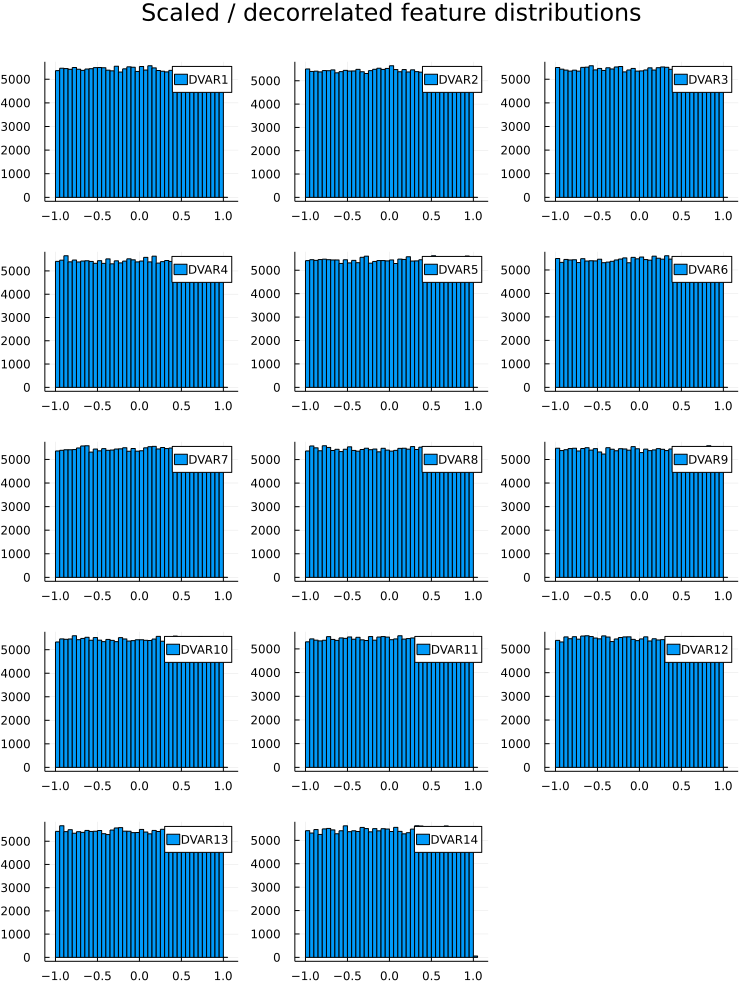

In [6]:
# plot features
l = @layout [grid(5, 3)]

subplots = []
for i in 1:14
    hist = histogram(x_scaled_df[:, "DVAR$i"], label="DVAR$i", bins=40)
    push!(subplots, hist)
end

plot(subplots..., layout=l, size=(750, 1000), plot_title="Scaled / decorrelated feature distributions")

In [7]:
# split into training and test sets
train_frac = 0.8
data_size = nrow(x_scaled_df)
train_size = trunc(Int, train_frac * data_size)

train_indexes = sample(1:data_size, train_size, replace=false)
test_indexes = (1:data_size)[(1:data_size) .∉ Ref(train_indexes)]

@assert(length(train_indexes) + length(test_indexes) == data_size)

x_train_df = x_scaled_df[train_indexes, :]; x_test_df = x_scaled_df[test_indexes, :];
y_train_df = y_scaled_df[train_indexes, :]; y_test_df = y_scaled_df[test_indexes, :];

In [8]:
# format to arrays
x_train = Float64.(Matrix(x_train_df)); x_test = Float64.(Matrix(x_test_df));
y_train = Float64.(Matrix(y_train_df)); y_test = Float64.(Matrix(y_test_df));

In [9]:
# get dimensions
x_dimension = size(x_train)[2];
y_dimension = size(y_train)[2];

## Neural nets with and without dropout layers

Here I choose a depth 6, width 200 neural network with a batch size of 1024, as previous analyses hinted at the fact that a neural network like this might be overfitting.

In one neural network, between each 200-width layer I add a dropout layer with dropout rate $0.75$.

In [10]:
# nets
function neuralnetwork()
    Chain(
        Dense(x_dimension, 150, x->σ.(x)),
        Dense(150, 150, x->σ.(x)),
        Dense(150, 150, x->σ.(x)),
        Dense(150, 150, x->σ.(x)),
        Dense(150, 150, x->σ.(x)),
        Dense(150, 150, x->σ.(x)),
        Dense(150, y_dimension)
    )
end

dropout_rate = 0.5
width = 4

function neuralnetworkwithdropout()
    Chain(
        Dense(x_dimension, 150, x->σ.(x)),
        (Chain(
            Dense(150, 150, x->σ.(x)),
            Dropout(dropout_rate),
        ) for _ in 1:width)...,
        Dense(150, y_dimension)
    )
end

neuralnetworkwithdropout (generic function with 1 method)

In [11]:
# organizing data into batches
batch_size = 1024
data_loader = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [12]:
# defining our model, optimization algorithm and loss function
m = neuralnetwork()
optimizer = ADAM()
loss(x, y) = Flux.mse(m(x), y)

# training
n_epochs = 2500
training_losses = Float32[]
epochs = Int32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss, Flux.params(m), data_loader, optimizer)
    push!(epochs, epoch)
    l = 0.
    for d in data_loader
        l += loss(d...)
    end
    println(" loss=$l")
    push!(training_losses, l)
end

epoch 1, loss=14.741084126489802
epoch 2, loss=9.947870199593472
epoch 3, loss=5.218242157633965
epoch 4, loss=4.241037756157414
epoch 5, loss=2.1254533842379195
epoch 6, loss=1.903689275684801
epoch 7, loss=1.7782358078626839
epoch 8, loss=1.7145572151061896
epoch 9, loss=1.6544380210427698
epoch 10, loss=1.6039812646432887
epoch 11, loss=1.5597258500645743
epoch 12, loss=1.5505574302876557
epoch 13, loss=1.5149674897380006
epoch 14, loss=1.4670061317703578
epoch 15, loss=1.4546441414400746
epoch 16, loss=1.4680943536854274
epoch 17, loss=1.3884175053113945
epoch 18, loss=1.3863751220707248
epoch 19, loss=1.3132759369956322
epoch 20, loss=1.3000632226369406
epoch 21, loss=1.2871422290007672
epoch 22, loss=1.242806603590227
epoch 23, loss=1.2017621659725488
epoch 24, loss=1.2397090706576461
epoch 25, loss=1.16969926378876
epoch 26, loss=1.1586019745339513
epoch 27, loss=1.1463859267072707
epoch 28, loss=1.1455578546753902
epoch 29, loss=1.134465584695298
epoch 30, loss=1.16182644205214

epoch 474, loss=0.8145891586904318
epoch 475, loss=0.8139822075024871
epoch 476, loss=0.8128073151235655
epoch 477, loss=0.8163796591482174
epoch 478, loss=0.8283754966148982
epoch 479, loss=0.8143689607669297
epoch 480, loss=0.8124049451049253
epoch 481, loss=0.8126798104361379
epoch 482, loss=0.8102928809770839
epoch 483, loss=0.8147409153879644
epoch 484, loss=0.8114749441280424
epoch 485, loss=0.8143248710401383
epoch 486, loss=0.8100112124623362
epoch 487, loss=0.8110498946862165
epoch 488, loss=0.8113555440005754
epoch 489, loss=0.8158043422284148
epoch 490, loss=0.815417767956078
epoch 491, loss=0.8118966751922089
epoch 492, loss=0.8150900452860939
epoch 493, loss=0.809326676326398
epoch 494, loss=0.8083602936027484
epoch 495, loss=0.8190588950300567
epoch 496, loss=0.8125196698933739
epoch 497, loss=0.807488730125607
epoch 498, loss=0.8088053435755451
epoch 499, loss=0.8114033788382145
epoch 500, loss=0.8143394879704708
epoch 501, loss=0.8114763798865023
epoch 502, loss=0.80800

epoch 943, loss=0.7475561782798209
epoch 944, loss=0.7496678464583921
epoch 945, loss=0.7461037613411967
epoch 946, loss=0.7443286849274947
epoch 947, loss=0.7457162671348353
epoch 948, loss=0.7417247739016324
epoch 949, loss=0.7452770694180428
epoch 950, loss=0.7414624503673882
epoch 951, loss=0.7469596288200694
epoch 952, loss=0.744329573098242
epoch 953, loss=0.7393261239171179
epoch 954, loss=0.7472317836208007
epoch 955, loss=0.7422213396168829
epoch 956, loss=0.7418317860481509
epoch 957, loss=0.7475310621771325
epoch 958, loss=0.7446527800657051
epoch 959, loss=0.7420301400597659
epoch 960, loss=0.740611017827871
epoch 961, loss=0.7436086642467776
epoch 962, loss=0.7439720158035862
epoch 963, loss=0.7390445690076048
epoch 964, loss=0.7446490787516777
epoch 965, loss=0.7434846737872146
epoch 966, loss=0.7414072823487698
epoch 967, loss=0.7403317181166423
epoch 968, loss=0.7511875416441673
epoch 969, loss=0.7415231115170372
epoch 970, loss=0.7485339622583922
epoch 971, loss=0.7424

epoch 1173, loss=0.7032768330251822
epoch 1174, loss=0.6994861245618003
epoch 1175, loss=0.70127545731052
epoch 1176, loss=0.7058776073448791
epoch 1177, loss=0.7023902552222285
epoch 1178, loss=0.703315736602246
epoch 1179, loss=0.7002981787149153
epoch 1180, loss=0.7005845341115754
epoch 1181, loss=0.7029065009817537
epoch 1182, loss=0.7085388342863319
epoch 1183, loss=0.6995099643500188
epoch 1184, loss=0.7030469123777303
epoch 1185, loss=0.7019962676071426
epoch 1186, loss=0.7002143992092281
epoch 1187, loss=0.7008511000172717
epoch 1188, loss=0.6998442696199987
epoch 1189, loss=0.7004445545587923
epoch 1190, loss=0.6990016325797617
epoch 1191, loss=0.6993415373079774
epoch 1192, loss=0.7023397813713785
epoch 1193, loss=0.702058953157131
epoch 1194, loss=0.7018029052584559
epoch 1195, loss=0.7072273075321108
epoch 1196, loss=0.6990396558379883
epoch 1197, loss=0.7002309840001407
epoch 1198, loss=0.6991127101099389
epoch 1199, loss=0.6927011768763223
epoch 1200, loss=0.6943937817302

epoch 1629, loss=0.6033363499203865
epoch 1630, loss=0.6031972015051108
epoch 1631, loss=0.603278278936298
epoch 1632, loss=0.6047306126676695
epoch 1633, loss=0.6038061547989215
epoch 1634, loss=0.6052888342974873
epoch 1635, loss=0.6019335672318783
epoch 1636, loss=0.6040446594856129
epoch 1637, loss=0.6068526858997847
epoch 1638, loss=0.5983619165012287
epoch 1639, loss=0.6040232749803586
epoch 1640, loss=0.5999332749807506
epoch 1641, loss=0.604064874054209
epoch 1642, loss=0.6094882442464628
epoch 1643, loss=0.6058070392639598
epoch 1644, loss=0.5985527471421864
epoch 1645, loss=0.604511677701865
epoch 1646, loss=0.6135243383438197
epoch 1647, loss=0.601005584461392
epoch 1648, loss=0.5994076113048374
epoch 1649, loss=0.5993455904555386
epoch 1650, loss=0.6000369042954569
epoch 1651, loss=0.6062413376952013
epoch 1652, loss=0.6109897092515965
epoch 1653, loss=0.6005514899432319
epoch 1654, loss=0.5976321634319134
epoch 1655, loss=0.598647814008411
epoch 1656, loss=0.59862096481576

epoch 2085, loss=0.5255153739378843
epoch 2086, loss=0.5258292929830424
epoch 2087, loss=0.5242986987818906
epoch 2088, loss=0.5212413000711975
epoch 2089, loss=0.5273626349216728
epoch 2090, loss=0.5205031901953212
epoch 2091, loss=0.5266090097339697
epoch 2092, loss=0.5326078973065439
epoch 2093, loss=0.5259684184461461
epoch 2094, loss=0.5223823304410041
epoch 2095, loss=0.5204609199733982
epoch 2096, loss=0.5206981958449265
epoch 2097, loss=0.5217087301588457
epoch 2098, loss=0.5201562763469191
epoch 2099, loss=0.5194272528061791
epoch 2100, loss=0.517588819278147
epoch 2101, loss=0.520543173538484
epoch 2102, loss=0.5178802219620562
epoch 2103, loss=0.5222134627403998
epoch 2104, loss=0.5196206504400153
epoch 2105, loss=0.5185770345890511
epoch 2106, loss=0.5183976365850607
epoch 2107, loss=0.5146607537389954
epoch 2108, loss=0.5166325848749608
epoch 2109, loss=0.5232381697965235
epoch 2110, loss=0.5221148525152922
epoch 2111, loss=0.5168118230110835
epoch 2112, loss=0.51956799484

epoch 2313, loss=0.49223882625528065
epoch 2314, loss=0.4989273645923729
epoch 2315, loss=0.48947292313771856
epoch 2316, loss=0.4944325108299813
epoch 2317, loss=0.4878095871467258
epoch 2318, loss=0.4849518344361062
epoch 2319, loss=0.4938225678035828
epoch 2320, loss=0.4952413179370681
epoch 2321, loss=0.4937529121611558
epoch 2322, loss=0.49292045949560925
epoch 2323, loss=0.4892610906841303
epoch 2324, loss=0.4892546688998997
epoch 2325, loss=0.4867815405238411
epoch 2326, loss=0.4883636252142443
epoch 2327, loss=0.4918373205584196
epoch 2328, loss=0.4845578856647512
epoch 2329, loss=0.49311167974417064
epoch 2330, loss=0.4897133424556617
epoch 2331, loss=0.48860805445807115
epoch 2332, loss=0.4915857235796143
epoch 2333, loss=0.48632597401854716
epoch 2334, loss=0.48847503996802877
epoch 2335, loss=0.4940559717724113
epoch 2336, loss=0.48849163198818707
epoch 2337, loss=0.4920946258357054
epoch 2338, loss=0.48708297911222437
epoch 2339, loss=0.48671979454513975
epoch 2340, loss=0

In [13]:
# organizing data into batches for dropout network
data_loader_2 = Flux.Data.DataLoader((x_train', y_train'), batchsize=batch_size, shuffle=true);

In [14]:
# defining our model, optimization algorithm and loss function
m_dropout = neuralnetworkwithdropout()
loss_dropout(x, y) = Flux.mse(m_dropout(x), y)

# training
training_losses_dropout = Float32[]

for epoch in 1:n_epochs
    print("epoch $epoch,")
    Flux.train!(loss_dropout, Flux.params(m_dropout), data_loader_2, optimizer)
    l = 0.
    for d in data_loader_2
        l += loss_dropout(d...)
    end
    println(" loss=$l")
    push!(training_losses_dropout, l)
end

epoch 1, loss=15.898473521748077
epoch 2, loss=15.375286912449495
epoch 3, loss=14.967553868693384
epoch 4, loss=14.886248305716627
epoch 5, loss=14.810514850808595
epoch 6, loss=12.208059978880494
epoch 7, loss=9.318844704794719
epoch 8, loss=8.81922039112337
epoch 9, loss=8.477505629856953
epoch 10, loss=5.200691036193368
epoch 11, loss=4.452270521241411
epoch 12, loss=4.067792616974005
epoch 13, loss=3.8702161604905245
epoch 14, loss=3.5256508862384677
epoch 15, loss=3.048827991438633
epoch 16, loss=2.779372806778962
epoch 17, loss=2.6065614144090925
epoch 18, loss=2.5257486899864383
epoch 19, loss=2.4019430491414306
epoch 20, loss=2.286347249059757
epoch 21, loss=2.21115681362972
epoch 22, loss=2.1352261709577762
epoch 23, loss=2.06283774099667
epoch 24, loss=2.026101830093603
epoch 25, loss=1.962980516143052
epoch 26, loss=1.960489672364061
epoch 27, loss=1.881457845373911
epoch 28, loss=1.8356069873573437
epoch 29, loss=1.7989494519444444
epoch 30, loss=1.8140952311389233
epoch 3

epoch 475, loss=1.081933824218498
epoch 476, loss=1.077093110951554
epoch 477, loss=1.0811760462214344
epoch 478, loss=1.079098646255762
epoch 479, loss=1.0783905676491832
epoch 480, loss=1.0845267788438961
epoch 481, loss=1.070729646298951
epoch 482, loss=1.0801627592486325
epoch 483, loss=1.0714971726952172
epoch 484, loss=1.0718533608836842
epoch 485, loss=1.0850051693505847
epoch 486, loss=1.0806345756823708
epoch 487, loss=1.0683511919259467
epoch 488, loss=1.0727375777969188
epoch 489, loss=1.0764316072493656
epoch 490, loss=1.0797417915547827
epoch 491, loss=1.0715472964289865
epoch 492, loss=1.0624506075367304
epoch 493, loss=1.0839861315425317
epoch 494, loss=1.082955416543626
epoch 495, loss=1.0791258071555228
epoch 496, loss=1.0766368884707784
epoch 497, loss=1.068910573836353
epoch 498, loss=1.0771091678912779
epoch 499, loss=1.0778245335391103
epoch 500, loss=1.085086618759871
epoch 501, loss=1.0805582441431574
epoch 502, loss=1.068169897674641
epoch 503, loss=1.0783473773

epoch 711, loss=1.0589916968120583
epoch 712, loss=1.0459317905237078
epoch 713, loss=1.043392510169499
epoch 714, loss=1.053875084817989
epoch 715, loss=1.061812093232399
epoch 716, loss=1.0364932207483206
epoch 717, loss=1.0487197191428905
epoch 718, loss=1.0465290167304429
epoch 719, loss=1.0502654646128442
epoch 720, loss=1.0559001014991332
epoch 721, loss=1.0467942641267927
epoch 722, loss=1.04939881516339
epoch 723, loss=1.0525196080561934
epoch 724, loss=1.0367072295976518
epoch 725, loss=1.0430531223674426
epoch 726, loss=1.0447818204322008
epoch 727, loss=1.0584283643480379
epoch 728, loss=1.0349711914359112
epoch 729, loss=1.0503996377020886
epoch 730, loss=1.0478615826121305
epoch 731, loss=1.053687940586555
epoch 732, loss=1.0606514387244985
epoch 733, loss=1.0468380581658843
epoch 734, loss=1.0494170491597197
epoch 735, loss=1.048074565910043
epoch 736, loss=1.0404998210518281
epoch 737, loss=1.0479783846918054
epoch 738, loss=1.0422769126338984
epoch 739, loss=1.047451933

epoch 947, loss=1.0368302978919073
epoch 948, loss=1.0383711841738956
epoch 949, loss=1.0303774331940776
epoch 950, loss=1.0286102427636925
epoch 951, loss=1.028451136799996
epoch 952, loss=1.0380451084455375
epoch 953, loss=1.0271308591582695
epoch 954, loss=1.04055157693195
epoch 955, loss=1.0303055049006715
epoch 956, loss=1.0255556863040918
epoch 957, loss=1.039132133304974
epoch 958, loss=1.0287782509108514
epoch 959, loss=1.0319590959982576
epoch 960, loss=1.0251330447807872
epoch 961, loss=1.0286392192431248
epoch 962, loss=1.0171934832541056
epoch 963, loss=1.0430370010489065
epoch 964, loss=1.0300423558630627
epoch 965, loss=1.03446897392339
epoch 966, loss=1.040530152811522
epoch 967, loss=1.0330400217820332
epoch 968, loss=1.0382122697424976
epoch 969, loss=1.0305765841007264
epoch 970, loss=1.0263177561049865
epoch 971, loss=1.029593597532524
epoch 972, loss=1.0360708768968494
epoch 973, loss=1.029570831338714
epoch 974, loss=1.03955024994993
epoch 975, loss=1.0391433355729

epoch 1406, loss=1.006235532029097
epoch 1407, loss=0.9980097622576873
epoch 1408, loss=1.0148171625295523
epoch 1409, loss=1.0047940296343758
epoch 1410, loss=1.0146278525456909
epoch 1411, loss=1.0201308744613362
epoch 1412, loss=1.025998799798588
epoch 1413, loss=1.0104999762633324
epoch 1414, loss=1.0098581889350702
epoch 1415, loss=1.008146267964676
epoch 1416, loss=1.0190589239916334
epoch 1417, loss=1.0121351538774634
epoch 1418, loss=1.0009500476431359
epoch 1419, loss=1.0266740970626551
epoch 1420, loss=1.0108544295598236
epoch 1421, loss=1.0156666785787543
epoch 1422, loss=1.014214486062325
epoch 1423, loss=1.0071817540006227
epoch 1424, loss=1.0157226615255692
epoch 1425, loss=1.0040128010811769
epoch 1426, loss=1.0118336173675226
epoch 1427, loss=1.019585621160831
epoch 1428, loss=1.021659016000914
epoch 1429, loss=1.0080592579439507
epoch 1430, loss=1.0108460566663136
epoch 1431, loss=1.00501739600597
epoch 1432, loss=1.006538680066314
epoch 1433, loss=1.0234318560916444
e

epoch 1863, loss=0.9942792532432014
epoch 1864, loss=1.0016242778121551
epoch 1865, loss=0.9979909958238738
epoch 1866, loss=1.0023223250759679
epoch 1867, loss=1.011511117620781
epoch 1868, loss=1.0004651030453502
epoch 1869, loss=0.9982071105276036
epoch 1870, loss=0.9968960948573846
epoch 1871, loss=1.001202040773886
epoch 1872, loss=1.0021931785400484
epoch 1873, loss=1.0015017371906039
epoch 1874, loss=1.0031354141635986
epoch 1875, loss=1.0022428681273696
epoch 1876, loss=0.9984524818545193
epoch 1877, loss=0.9939854198194841
epoch 1878, loss=1.0020142818371736
epoch 1879, loss=1.0051096126815509
epoch 1880, loss=1.0103959697911105
epoch 1881, loss=1.0054555011703228
epoch 1882, loss=0.9980188536535586
epoch 1883, loss=1.0009111903625834
epoch 1884, loss=1.0200709063681246
epoch 1885, loss=1.0082664275586155
epoch 1886, loss=1.0059984693139945
epoch 1887, loss=0.9986432892081485
epoch 1888, loss=0.9954883828729555
epoch 1889, loss=0.992936848965181
epoch 1890, loss=1.001697489383

epoch 2319, loss=0.9906142646990443
epoch 2320, loss=0.9923268554367687
epoch 2321, loss=0.988213345863877
epoch 2322, loss=0.9902881178904503
epoch 2323, loss=0.9921123978714613
epoch 2324, loss=0.982712059531622
epoch 2325, loss=0.9908868640663232
epoch 2326, loss=1.0002231725787942
epoch 2327, loss=0.9888043941908512
epoch 2328, loss=0.9969030628584024
epoch 2329, loss=0.9917769599117883
epoch 2330, loss=0.9998341179911981
epoch 2331, loss=0.9945865994039464
epoch 2332, loss=1.0065848739136365
epoch 2333, loss=0.9842190086098827
epoch 2334, loss=0.9953764466065677
epoch 2335, loss=0.9930060938036075
epoch 2336, loss=1.002642436397159
epoch 2337, loss=0.9917866630800641
epoch 2338, loss=1.0008754770412438
epoch 2339, loss=1.001757275558899
epoch 2340, loss=0.99589190022444
epoch 2341, loss=0.981869924503151
epoch 2342, loss=0.9900626765102303
epoch 2343, loss=0.9948150948821374
epoch 2344, loss=0.9917174812341636
epoch 2345, loss=0.9809015040903166
epoch 2346, loss=1.001655215117703


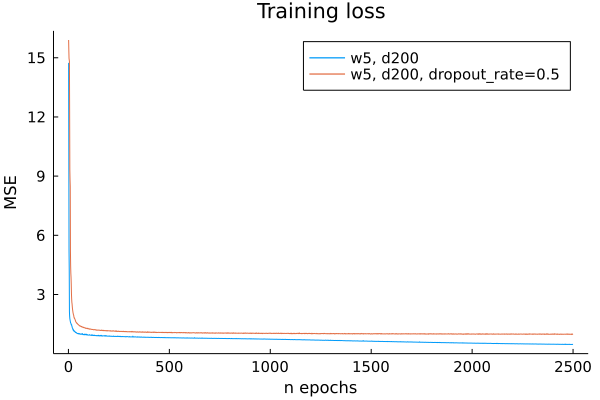

In [15]:
# plot training history
plot(epochs, training_losses;
    title="Training loss", xlabel="n epochs", ylabel="MSE", legend=false,
    label="w5, d200", dpi=400, grid=false, xtickfontsize=10, ytickfontsize=10, legendfontsize=10)
plot!(epochs, training_losses_dropout;
    legend=true, label="w5, d200, dropout_rate=$dropout_rate")

#savefig("corr_decorr_training.png")

In [16]:
Flux.testmode!(m_dropout, true)

Chain(
  Dense(14 => 150, #61),                # 2_250 parameters
  Chain(
    Dense(150 => 150, #63),             # 22_650 parameters
    Dropout(0.5),
  ),
  Chain(
    Dense(150 => 150, #63),             # 22_650 parameters
    Dropout(0.5),
  ),
  Chain(
    Dense(150 => 150, #63),             # 22_650 parameters
    Dropout(0.5),
  ),
  Chain(
    Dense(150 => 150, #63),             # 22_650 parameters
    Dropout(0.5),
  ),
  Dense(150 => 6),                      # 906 parameters
)                   # Total: 12 arrays, 93_756 parameters, 367.298 KiB.

## Model evaluation

In [17]:
y_train_preds = m(x_train')'
y_test_preds = m(x_test')'

y_train_preds_dropout = m_dropout(x_train')'
y_test_preds_dropout = m_dropout(x_test')'

43459×6 adjoint(::Matrix{Float64}) with eltype Float64:
  0.431805   -0.466561   -0.724836  -0.912738  -0.52345    -0.539367
  0.118501    0.215846   -0.775105  -0.876426  -0.139822   -0.168707
  0.899511    0.0783258  -0.380485  -0.926176  -0.327071   -0.3578
  0.480142    0.0473182  -0.542264  -0.871574   0.0465634   0.0106387
  0.576352    0.394905   -0.454139  -0.933727  -0.559203   -0.576055
 -0.0555129  -0.323307   -0.342694  -0.90006   -0.227535   -0.251935
  0.198418   -0.25451    -0.839798  -0.902508  -0.480282   -0.489331
  0.632947    0.0840936  -0.585495  -0.913979  -0.482106   -0.503015
  0.901062    0.380864   -0.182624  -0.933474  -0.285004   -0.318482
 -0.0914494   0.109538   -0.157934  -0.927246  -0.368533   -0.38957
  0.733877    0.0102753  -0.631195  -0.89698   -0.287064   -0.311336
  0.382861   -0.330696   -0.803551  -0.879356  -0.24974    -0.265213
  0.318662   -0.736862   -0.562735  -0.934071  -0.585126   -0.593205
  ⋮                                              

In [18]:
# rsquared
function r2score(yvec, ŷvec)
    ymean = mean(yvec)
    numerator = sum((y - ŷ)^2 for (y, ŷ) in zip(yvec, ŷvec))
    denominator = sum((y - ymean)^2 for y in yvec)
    1 - numerator / denominator
end
    
function r2score_multidim(ys, ŷs, multioutput::String="uniformaverage")
    d = size(ys, 2)
    r2score_rawvalues = [r2score(ys[:, i], ŷs[:, i]) for i in 1:d]
    if multioutput == "rawvalues"
        return r2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(r2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

r2score_multidim (generic function with 2 methods)

In [19]:
println("without dropout:")
r2_train = r2score_multidim(y_train, y_train_preds)
r2_test = r2score_multidim(y_test, y_test_preds)
println("r2 on training set: $r2_train")
println("r2 on test set: $r2_test")

println("with dropout")
r2_train_dropout = r2score_multidim(y_train, y_train_preds_dropout)
r2_test_dropout = r2score_multidim(y_test, y_test_preds_dropout)
println("r2 on training set: $r2_train_dropout")
println("r2 on test set: $r2_test_dropout")

without dropout:
r2 on training set: 0.9545934517184843
r2 on test set: 0.8907318415175993
with dropout
r2 on training set: 0.85908182703597
r2 on test set: 0.861266059828377


In [20]:
# adjusted rsquared
function adjustedr2score(yvec, ŷvec, p::Int)
    M = size(yvec, 1)
    return 1 - (1 - r2score(yvec, ŷvec)) * (M - 1) / (M - p - 1)
end

function adjustedr2score_multidim(ys, ŷs, p::Int, multioutput::String="uniformaverage")
    d = size(ys, 2)
    adjustedr2score_rawvalues = [adjustedr2score(ys[:, i], ŷs[:, i], p) for i in 1:d]
    if multioutput == "rawvalues"
        return adjustedr2score_rawvalues
    elseif multioutput == "uniformaverage"
        return mean(adjustedr2score_rawvalues)
    else
        error("multioutput must be one of \"rawvalues\" or \"uniformaverage\"")
    end
end

adjustedr2score_multidim (generic function with 2 methods)

In [21]:
println("without dropout")
adjustedr2_train = adjustedr2score_multidim(y_train, y_train_preds, size(x_train, 2))
adjustedr2_test = adjustedr2score_multidim(y_test, y_test_preds, size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train")
println("adjustedr2 on test set: $adjustedr2_test")

println("with dropout")
adjustedr2_train_dropout = adjustedr2score_multidim(y_train, y_train_preds_dropout, size(x_train, 2))
adjustedr2_test_dropout = adjustedr2score_multidim(y_test, y_test_preds_dropout, size(x_test, 2))
println("adjustedr2 on training set: $adjustedr2_train_dropout")
println("adjustedr2 on test set: $adjustedr2_test_dropout")

without dropout
adjustedr2 on training set: 0.954589794513714
adjustedr2 on test set: 0.890696629423438
with dropout
adjustedr2 on training set: 0.8590704769855065
adjustedr2 on test set: 0.8612213522700859


In [22]:
# MAPEs
function mape(preds, trues)
    return Statistics.mean((broadcast(abs, preds-trues) ./ broadcast(abs, trues)))
end

println("MAPEs on test sets")
for i in 1:y_dimension
    temp_train_trues_normalized = y_train[:, i]
    temp_test_trues_normalized = y_test[:, i]
    
    temp_train_preds_normalized = y_train_preds[:, i]
    temp_test_preds_normalized = y_test_preds[:, i]
    
    temp_train_preds_normalized_dropout = y_train_preds_dropout[:, i]
    temp_test_preds_normalized_dropout = y_test_preds_dropout[:, i]
    
    # unnormalize
    y_scaler = MinMaxScaler(0., 0.)
    fit!(y_scaler, y_df[!, "OBJ$i"])
    
    temp_train_trues_original = inverse_transform(y_scaler, temp_train_trues_normalized)
    temp_test_trues_original = inverse_transform(y_scaler, temp_test_trues_normalized)
    temp_train_preds_original = inverse_transform(y_scaler, temp_train_preds_normalized)
    temp_test_preds_original = inverse_transform(y_scaler, temp_test_preds_normalized)
    temp_train_preds_original_dropout = inverse_transform(y_scaler, temp_train_preds_normalized_dropout)
    temp_test_preds_original_dropout = inverse_transform(y_scaler, temp_test_preds_normalized_dropout)
    
    println(
        "OBJ$i WITHOUT dropout: ",
        mape(temp_test_preds_original, temp_test_trues_original)
    )
    println(
        "OBJ$i WITH dropout: ",
        mape(temp_test_preds_original_dropout, temp_test_trues_original)
    )
end

MAPEs on test sets
OBJ1 WITHOUT dropout: 0.019345607682590256
OBJ1 WITH dropout: 0.034511724705229535
OBJ2 WITHOUT dropout: 0.01955013008360268
OBJ2 WITH dropout: 0.01851207031145429
OBJ3 WITHOUT dropout: 0.019016632922776992
OBJ3 WITH dropout: 0.04254784096468838
OBJ4 WITHOUT dropout: 0.08737391174147224
OBJ4 WITH dropout: 0.19112830182815568
OBJ5 WITHOUT dropout: 0.12830577229134088
OBJ5 WITH dropout: 0.12496139471393179
OBJ6 WITHOUT dropout: 0.1300212186230503
OBJ6 WITH dropout: 0.12483979548518633


In [23]:
i = 7
println("true: ", y_test[i, :])
println("predicted w/o dropout: ", y_test_preds[i, :])
println("predicted with dropout: ", y_test_preds_dropout[i, :])

true: [0.1987343066543268, -0.15243912273038362, -0.8937151189651447, -0.8520834750768909, -0.3143684632530205, -0.6076358278977272]
predicted w/o dropout: [0.15073122950737394, -0.15154679274163602, -0.8931092614605189, -0.853191093920177, -0.520783989397479, -0.41674968274523777]
predicted with dropout: [0.19841765698285468, -0.2545101415306653, -0.8397977692838328, -0.9025083542618618, -0.48028150009315734, -0.4893314741768163]
